# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
import os

import findspark

# findspark.init('/home/brunowdev/spark-2.4.5-bin-hadoop2.6/')

findspark.init('/home/bruno/LIBS/spark')

import evaluators

In [2]:
from datetime import datetime

import numpy as np

from sklearn.metrics import confusion_matrix

from pyspark.sql import SparkSession

from pyspark.sql.functions import min as smin, max as smax, sum as ssum, round as sround, abs as sabs, pow as spow
from pyspark.sql.functions import isnan, isnull, when, first, avg, sqrt, last, count, countDistinct, col, lag, lead, coalesce, lit, split, trim

from pyspark.sql.window import Window
from pyspark.sql.functions import to_date, date_format, from_unixtime, to_timestamp

from pyspark.sql.types import DateType, TimestampType, IntegerType
 
import jupyter_utils as j

from pyspark import SparkContext

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, MaxAbsScaler, Normalizer, MinMaxScaler, StringIndexer, VectorAssembler

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
 
from pyspark.ml.evaluation import BinaryClassificationEvaluator, Evaluator
from pyspark import since, keyword_only

from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report


In [3]:
j.reload(j)

In [4]:
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

spark.sparkContext.setLogLevel('INFO')

In [5]:
spark.sparkContext.getConf().getAll()

[('spark.sql.catalogImplementation', 'hive'),
 ('spark.driver.memory', '6g'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.app.id', 'local-1589240730336'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '34785'),
 ('spark.driver.host', '192.168.0.102'),
 ('spark.ui.showConsoleProgress', 'true')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [6]:
def spark_read(spark):
    return spark.read.option('inferSchema', 'true').option('header', 'true').option('encoding', 'utf-8')

def load_medium_json_file(spark):
    df = spark_read(spark).json('medium_sparkify_event_data.json')
    return df
    
def load_full_json_file(spark):
    df = spark_read(spark).json('full_sparkify_event_data.json')
    return df

def load_full_csv_file(spark):
    df = spark_read(spark).csv('sparkify_full_csv_data.csv')
    return df

In [8]:
df = load_full_csv_file(spark)

In [7]:
df = load_full_json_file(spark)

In [8]:
df.cache()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [9]:
log4jLogger = spark.sparkContext._jvm.org.apache.log4j

LOGGER = log4jLogger.LogManager.getLogger('driver_logger')

def info(message, print_on_notebook = True):
    LOGGER.info(message)
    
    if print_on_notebook:
        print(message)
    
info('Logger instance created')

Logger instance created


In [10]:
from pyspark import StorageLevel

def set_storage_on_memory(df):
    df.persist(StorageLevel.MEMORY_ONLY)
    
set_storage_on_memory(df)

In [11]:
df.count()

26259199

In [12]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [15]:
CHURN_CANCELLATION_PAGE = 'Cancellation Confirmation'
REGISTRATION_PAGE = 'Submit Registration'
milliseconds_to_hours = 3600 * 1000
minutes_to_hours = 60 * 60
TRUE = 1
FALSE = 0

def clean_dataframe(df):
    
    info('Starting data cleaning...')
    
    total_before = df.count()
    
    # Keep only logged records
    df = df.where(df.auth.isin(['Logged In', 'Cancelled']))
    
    # Records without userId
    df = df.where(col('userId').isNotNull())
    
    # Create a date column for the event
    df = df.withColumn('date', from_unixtime(col('ts') / 1000).cast(DateType()))
    
    # Relevant windows
    w_session = Window.partitionBy('sessionId').orderBy('ts')
    w_user_session = Window.partitionBy('sessionId', 'userId').orderBy('ts').rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
    w_user = Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
    
    # Create features
    df = df.withColumn('previous_page', lag(df.page).over(w_session))
    df = df.withColumn('last_event_ts', last(col('ts')).over(w_user))
    df = df.withColumn('last_page', last(col('page')).over(w_user))
    df = df.withColumn('register_page', first(col('previous_page')).over(w_user))
    df = df.withColumn('first_ts', first(col('ts')).over(w_user))
    df = df.withColumn('ts_elapsed', last(df.ts).over(w_session) - first(df.ts).over(w_user_session))
    df = df.withColumn('session_duration', smax(df.ts_elapsed).over(w_user_session))
     
    info('Finished data cleaning...')
    info(f'Number of removed rows: {total_before - df.count()}')
    
    return df

In [16]:
df = clean_dataframe(df)

Starting data cleaning...
Finished data cleaning...
Number of removed rows: 778479


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [16]:
df.groupBy('page').count().orderBy('count', ascending = False).show(50)

+--------------------+--------+
|                page|   count|
+--------------------+--------+
|            NextSong|20850272|
|                Home| 1343102|
|           Thumbs Up| 1151465|
|     Add to Playlist|  597921|
|         Roll Advert|  385212|
|          Add Friend|  381664|
|               Login|  296350|
|              Logout|  296005|
|         Thumbs Down|  239212|
|           Downgrade|  184240|
|                Help|  155100|
|            Settings|  147074|
|               About|   92759|
|             Upgrade|   50507|
|       Save Settings|   29516|
|               Error|   25962|
|      Submit Upgrade|   15135|
|    Submit Downgrade|    6494|
|              Cancel|    5003|
|Cancellation Conf...|    5003|
|            Register|     802|
| Submit Registration|     401|
+--------------------+--------+



Some questions about the data:

- Are errors related to downgrading canceling the service?
- Having a certain number of friends or a sense of community can decrease the churn?
- Thumbs down are related to churn? (could the quality of the songs catalog affect the churn)
- The advertising is not annoying the users?
- Users with stay connected for more time have less change to churn?
- Is the home page relevant?
- Users, who access the downgrade page are how much more willing to churn?

In [ ]:
df.groupBy('status').count().orderBy('count', ascending = False).show(20)

In [ ]:
df.filter('userId = 92').groupBy('page').count().orderBy('count', ascending = False).show(50)

In [ ]:
df.filter('userId = 92').groupBy('page').count().orderBy('count', ascending = False).show(50)

In [ ]:
df.filter('userId = 92').groupBy('userAgent').count().orderBy('count', ascending = False).show(50, False)

In [ ]:
df.filter('userId = 92 and song != \'null\' ').groupBy('song').count().orderBy('count', ascending = False).show(50, False)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [17]:
def create_session_dimension(df):
    
    # sessions from the user
    df_sessions = df.orderBy(df.sessionId).groupBy('sessionId', 'userId').agg(
        smax(df.ts).alias('max_event_ts'),
        smin(df.ts).alias('min_event_ts'),
        ssum(df.length).alias('session_n_total_playback'), # Based on songs length
        count(when(df.page == 'Thumbs Up', True)).alias("session_n_likes"),
        count(when(df.page == 'Thumbs Down', True)).alias("session_n_dislikes"),
        count(when(df.page == 'NextSong', True)).alias("session_n_songs"),
        count(when(df.page == 'Add Friend', True)).alias("session_n_friends"),
        count(when(df.page == 'Add to Playlist', True)).alias("session_n_add_playlist"),
        count(when(df.page == 'Home', True)).alias("session_n_home"),
        count(when(df.page == 'Roll Advert', True)).alias("session_n_ads"),
        count(when(df.page == 'Help', True)).alias("session_n_help"),
        count(when(df.page == 'Error', True)).alias("session_n_error"),
        count(when(df.page == 'Settings', True)).alias("session_n_sets"),
        count(col('page')).alias('session_n_actions'),
        first(col('session_duration')).alias('session_duration')
    ) 
    
    # Calculate the interval until the next session
    w_user_sessions_interval = Window.partitionBy('userId').orderBy('min_event_ts')
    df_sessions = df_sessions.withColumn('interval_to_session', col('min_event_ts') - lag(col('max_event_ts')).over(w_user_sessions_interval))
    
    # Calculate average time in hours for each session
    df_session_time = df_sessions.groupBy('userId').agg(
        # (avg(df_sessions.session_duration) / milliseconds_to_hours).alias('session_hours')
        (avg(df_sessions.session_n_total_playback) / minutes_to_hours).alias('session_hours_playing')
    )
    df_sessions = df_sessions.join(df_session_time, on = 'userId')
    
    # We should remove the null lines before count/group to not account 2 times the mean interval
    df_sessions = df_sessions.groupBy('userId').agg(  
        (avg(df_sessions.interval_to_session) / milliseconds_to_hours).alias('session_avg_time_away'),
        ((avg(df_sessions.session_n_total_playback) / minutes_to_hours) / first(col('session_hours_playing'))).alias('session_avg_playback'), 
        (avg(df_sessions.session_n_likes) / first(col('session_hours_playing'))).alias('session_avg_likes'),
        (avg(df_sessions.session_n_dislikes) / first(col('session_hours_playing'))).alias('session_avg_dislikes'),
        (avg(df_sessions.session_n_songs) / first(col('session_hours_playing'))).alias('session_avg_songs'),
        (avg(df_sessions.session_n_friends) / first(col('session_hours_playing'))).alias('session_avg_friends'),
        (avg(df_sessions.session_n_add_playlist) / first(col('session_hours_playing'))).alias('session_avg_added_playlist'),
        (avg(df_sessions.session_n_home) / first(col('session_hours_playing'))).alias('session_avg_home'),
        (avg(df_sessions.session_n_ads) / first(col('session_hours_playing'))).alias('session_avg_ads'),
        (avg(df_sessions.session_n_help) / first(col('session_hours_playing'))).alias('session_avg_help'),
        (avg(df_sessions.session_n_error) / first(col('session_hours_playing'))).alias('session_avg_errors'),
        (avg(df_sessions.session_n_sets) / first(col('session_hours_playing'))).alias('session_avg_settings'),
        (avg(df_sessions.session_n_actions) / first(col('session_hours_playing'))).alias('session_avg_actions')
    )
    
    return df_sessions

def create_user_dimension(df):
    
    df_user_profile = df.groupby('userId')\
        .agg( 

            # first(col('state')).alias('state'),
            first(when(col('gender') == 'M', TRUE).otherwise(FALSE)).alias('male'),

            smin(col('first_ts')).alias('ts_start'),
            smax(col('last_event_ts')).alias('ts_end'),        
        
            ((smax(col('last_event_ts')) - smin(col('first_ts'))) / milliseconds_to_hours).alias('time_window'),
        
            # Subscription
            count(when(col('page') == 'Submit Downgrade', True)).alias('n_downgrades'),
            count(when(col('page') == 'Submit Upgrade', True)).alias('n_upgrades'),
            last(when(col('level') == 'paid', TRUE).otherwise(FALSE)).alias('paid'),
            first(when(col('last_page') == CHURN_CANCELLATION_PAGE, TRUE).otherwise(FALSE)).alias('canceled'),

            # Streaming
            count(when(col('page') == 'NextSong', True)).alias('n_songs'),
            count(when(col('page') == 'Thumbs Up', True)).alias('n_likes'),
            count(when(col('page') == 'Thumbs Down', True)).alias('n_dislikes'),

            (count(when(col('page') == 'NextSong', True))/count(when(col('page') == 'Roll Advert', True))).alias('n_ads_over_songs'),
            (count(when(col('page') == 'NextSong', True))/count(when(col('page') == 'Thumbs Up', True))).alias('n_likes_over_songs'),
            (count(when(col('page') == 'NextSong', True))/count(when(col('page') == 'Thumbs Down', True))).alias('n_dislikes_over_songs'),
            (count(when(col('page') == 'Thumbs Up', True))/count(when(col('page') == 'Thumbs Down', True))).alias('n_likes_over_dislikes'),

            countDistinct(col('sessionId')).alias('n_sess'),
            (avg(col('session_duration')) / milliseconds_to_hours).alias('avg_session_duration'),

            # Community
            count(when(col('page') == 'Add Friend', True)).alias('n_friends'),
            count(when(col('page') == 'Add to Playlist', True)).alias('n_added_to_playlist'),

            # Other
            count(when(col('page') == 'Home', True)).alias('n_home'),
            count(when(col('page') == 'Roll Advert', True)).alias('n_ads'),
            count(when(col('page') == 'Help', True)).alias('n_help'),
            count(when(col('page') == 'Error', True)).alias('n_errors'),
            count(when(col('page') == 'Settings', True)).alias('n_settings'),
            count(col('page')).alias('n_actions')
        )
    
    
    # Location
    # states = list(map(lambda c: c[0].strip(), df.select(['state']).distinct().rdd.collect()))
    # for state in states:
    #    df_user_profile = df_user_profile.withColumn(state.lower(), when(df_user_profile.state == state, 1).otherwise(0))
    
    return df_user_profile

def create_days_dimension(df):
    
    df_unique_days = df.groupby('userId').agg(countDistinct('date').alias('n_days'))
    
    df_daily_actions = df.groupby('userId', 'date').agg(count('page').alias('total'))
    df_daily_actions = df_daily_actions.groupby('userId').agg(avg('total').alias('avg_daily_actions')) 

    df_days = df_unique_days.join(df_daily_actions, df_unique_days.userId == df_daily_actions.userId)
    
    # Remove duplicated column after join
    df_days = df_days.drop(df_daily_actions.userId)
    
    return df_days

def sort_features(df, columns_order):
    _columns = df.columns
    _columns.sort()
    
    for _idx, _val in list(enumerate(columns_order)):
        _columns.pop(_columns.index(_val))
        _columns.insert(_idx, _val)
        
    assert len(_columns) == len(df.columns)

    return _columns

In [18]:
binary_features = [ 'paid', 'male' ]

numeric_features = [
    'avg_daily_actions',
    'avg_session_duration', 
    'n_actions',
    'n_added_to_playlist',
    'n_ads',
    'n_days',
    'n_dislikes',
    'n_downgrades',
    'n_errors',
    'n_friends',
    'n_help',
    'n_home',
    'n_likes',
    'n_sess',
    'n_settings',
    'n_songs',
    'n_upgrades', 
    'n_ads_over_songs',
    'n_likes_over_songs',
    'n_dislikes_over_songs',
    'n_likes_over_dislikes',
    'session_avg_actions',
    'session_avg_added_playlist',
    'session_avg_ads',
    'session_avg_dislikes',
    'session_avg_errors',
    'session_avg_friends',
    'session_avg_help',
    'session_avg_home',
    'session_avg_likes',
    'session_avg_playback',
    'session_avg_settings',
    'session_avg_songs',
    'session_avg_time_away',
    'time_window'
]

columns_all = [
    'canceled',
    'male',
    'paid',
    'avg_daily_actions',
    'avg_session_duration', 
    'n_actions',
    'n_added_to_playlist',
    'n_ads',
    'n_days',
    'n_dislikes',
    'n_downgrades',
    'n_errors',
    'n_friends',
    'n_help',
    'n_home',
    'n_likes',
    'n_sess',
    'n_settings',
    'n_songs',
    'n_upgrades', 
    'n_ads_over_songs',
    'n_likes_over_songs',
    'n_dislikes_over_songs',
    'n_likes_over_dislikes',
    'session_avg_actions',
    'session_avg_added_playlist',
    'session_avg_ads',
    'session_avg_dislikes',
    'session_avg_errors',
    'session_avg_friends',
    'session_avg_help',
    'session_avg_home',
    'session_avg_likes',
    'session_avg_playback',
    'session_avg_settings',
    'session_avg_songs',
    'session_avg_time_away',
    'time_window'
]

columns_to_train = [
    'male',
    'paid',
    'avg_daily_actions',
    'avg_session_duration', 
    'n_actions',
    'n_added_to_playlist',
    'n_ads',
    'n_days',
    'n_dislikes',
    'n_downgrades',
    'n_errors',
    'n_friends',
    'n_help',
    'n_home',
    'n_likes',
    'n_sess',
    'n_settings',
    'n_songs',
    'n_upgrades', 
    'n_ads_over_songs',
    'n_likes_over_songs',
    'n_dislikes_over_songs',
    'n_likes_over_dislikes',
    'session_avg_actions',
    'session_avg_added_playlist',
    'session_avg_ads',
    'session_avg_dislikes',
    'session_avg_errors',
    'session_avg_friends',
    'session_avg_help',
    'session_avg_home',
    'session_avg_likes',
    'session_avg_playback',
    'session_avg_settings',
    'session_avg_songs',
    'session_avg_time_away',
    'time_window'
]

#### Transform the data - create a unique row per user

In [19]:
df_sessions = create_session_dimension(df)
df_days = create_days_dimension(df)

df_users = create_user_dimension(df)
df_users = df_users.orderBy(df_users.userId).join(df_days, on = 'userId')

_columns = sort_features(df_users, [ 'userId', 'male', 'paid', 'canceled'])
_columns = list(set(df_users.schema.names + df_sessions.schema.names) - set(['ts_start', 'ts_end', 'state']))

df_users = df_users.orderBy(df_users.userId).join(df_sessions, on = 'userId').select(_columns) 

In [20]:
# Create the new dataframe
df_users = df_users.select(columns_all).fillna(0)

In [21]:
df_users.printSchema()

root
 |-- canceled: integer (nullable = true)
 |-- male: integer (nullable = true)
 |-- paid: integer (nullable = true)
 |-- avg_daily_actions: double (nullable = false)
 |-- avg_session_duration: double (nullable = false)
 |-- n_actions: long (nullable = false)
 |-- n_added_to_playlist: long (nullable = false)
 |-- n_ads: long (nullable = false)
 |-- n_days: long (nullable = false)
 |-- n_dislikes: long (nullable = false)
 |-- n_downgrades: long (nullable = false)
 |-- n_errors: long (nullable = false)
 |-- n_friends: long (nullable = false)
 |-- n_help: long (nullable = false)
 |-- n_home: long (nullable = false)
 |-- n_likes: long (nullable = false)
 |-- n_sess: long (nullable = false)
 |-- n_settings: long (nullable = false)
 |-- n_songs: long (nullable = false)
 |-- n_upgrades: long (nullable = false)
 |-- n_ads_over_songs: double (nullable = false)
 |-- n_likes_over_songs: double (nullable = false)
 |-- n_dislikes_over_songs: double (nullable = false)
 |-- n_likes_over_dislikes: 

In [22]:
df_users.cache()

DataFrame[canceled: int, male: int, paid: int, avg_daily_actions: double, avg_session_duration: double, n_actions: bigint, n_added_to_playlist: bigint, n_ads: bigint, n_days: bigint, n_dislikes: bigint, n_downgrades: bigint, n_errors: bigint, n_friends: bigint, n_help: bigint, n_home: bigint, n_likes: bigint, n_sess: bigint, n_settings: bigint, n_songs: bigint, n_upgrades: bigint, n_ads_over_songs: double, n_likes_over_songs: double, n_dislikes_over_songs: double, n_likes_over_dislikes: double, session_avg_actions: double, session_avg_added_playlist: double, session_avg_ads: double, session_avg_dislikes: double, session_avg_errors: double, session_avg_friends: double, session_avg_help: double, session_avg_home: double, session_avg_likes: double, session_avg_playback: double, session_avg_settings: double, session_avg_songs: double, session_avg_time_away: double, time_window: double]

In [23]:
df_users.show(1, True, vertical = True)

-RECORD 0-----------------------------------------
 canceled                   | 1                   
 male                       | 1                   
 paid                       | 0                   
 avg_daily_actions          | 59.86363636363637   
 avg_session_duration       | 5.62298764025985    
 n_actions                  | 1317                
 n_added_to_playlist        | 25                  
 n_ads                      | 74                  
 n_days                     | 22                  
 n_dislikes                 | 33                  
 n_downgrades               | 1                   
 n_errors                   | 3                   
 n_friends                  | 14                  
 n_help                     | 8                   
 n_home                     | 44                  
 n_likes                    | 53                  
 n_sess                     | 22                  
 n_settings                 | 9                   
 n_songs                    | 1

In [24]:
from pyspark.sql.window import Window

import sys

_columns_to_check_outliers = [ 
     'avg_daily_actions', 
     'avg_session_duration',  
     'session_avg_actions', 
     'session_avg_added_playlist', 
     'session_avg_ads', 
     'session_avg_dislikes', 
     'session_avg_errors', 
     'session_avg_friends', 
     'session_avg_help', 
     'session_avg_home', 
     'session_avg_likes', 
     'session_avg_playback', 
     'session_avg_settings', 
     'session_avg_songs', 
     'session_avg_time_away', 
     'time_window'
]

w = Window().partitionBy()

def z_score(col, w):
    _avg_ = avg(col).over(w)
    avg_sq = avg(spow(col, 2)).over(w)
    sd_ = sqrt(avg_sq - spow(_avg_, 2))
    return sabs((col - _avg_) / sd_)

for c in _columns_to_check_outliers:
    df_users = df_users.withColumn(f'zscore_{c}', z_score(col(c), w))
    

zscore_columns = []

for c in _columns_to_check_outliers:
    zscore_columns.append(f'zscore_{c}')
    
_query = ''
_threshold = 3

for c in zscore_columns:
    _begin = ' and ' if len(_query) > 0 else ''
    _query += f'{_begin}{c} < {_threshold}'

In [25]:
print(f'Before: {df_users.count()}')
df_users = df_users.filter(_query)
print(f'After: {df_users.count()}')

Before: 22277
After: 20007


In [27]:
print(f'Before: {df_users.count()}')
df_users = df_users.filter(_query)
print(f'After: {df_users.count()}')

Before: 22278
After: 20134


In [33]:
df_users.show(1, True, vertical = True)

-RECORD 0-------------------------------------------------
 canceled                          | 0                    
 male                              | 1                    
 paid                              | 1                    
 avg_daily_actions                 | 56.833333333333336   
 avg_session_duration              | 8.064825676115998    
 n_actions                         | 682                  
 n_added_to_playlist               | 20                   
 n_ads                             | 3                    
 n_days                            | 12                   
 n_dislikes                        | 10                   
 n_downgrades                      | 1                    
 n_errors                          | 3                    
 n_friends                         | 12                   
 n_help                            | 5                    
 n_home                            | 27                   
 n_likes                           | 25                 

In [26]:
df_users.cache()

DataFrame[canceled: int, male: int, paid: int, avg_daily_actions: double, avg_session_duration: double, n_actions: bigint, n_added_to_playlist: bigint, n_ads: bigint, n_days: bigint, n_dislikes: bigint, n_downgrades: bigint, n_errors: bigint, n_friends: bigint, n_help: bigint, n_home: bigint, n_likes: bigint, n_sess: bigint, n_settings: bigint, n_songs: bigint, n_upgrades: bigint, n_ads_over_songs: double, n_likes_over_songs: double, n_dislikes_over_songs: double, n_likes_over_dislikes: double, session_avg_actions: double, session_avg_added_playlist: double, session_avg_ads: double, session_avg_dislikes: double, session_avg_errors: double, session_avg_friends: double, session_avg_help: double, session_avg_home: double, session_avg_likes: double, session_avg_playback: double, session_avg_settings: double, session_avg_songs: double, session_avg_time_away: double, time_window: double, zscore_avg_daily_actions: double, zscore_avg_session_duration: double, zscore_session_avg_actions: double

In [12]:
### WARN: Only round to display
# Enforces the order for some columns
df_users.select([sround(c, 0).cast(dataType = IntegerType()).alias(c) for c in columns_all]).show(2, True, vertical = True)

-RECORD 0--------------------------
 canceled                   | 0    
 male                       | 1    
 paid                       | 1    
 avg_daily_actions          | 57   
 avg_session_duration       | 8    
 n_actions                  | 682  
 n_added_to_playlist        | 20   
 n_ads                      | 3    
 n_days                     | 12   
 n_dislikes                 | 10   
 n_downgrades               | 1    
 n_errors                   | 3    
 n_friends                  | 12   
 n_help                     | 5    
 n_home                     | 27   
 n_likes                    | 25   
 n_sess                     | 9    
 n_settings                 | 4    
 n_songs                    | 557  
 n_upgrades                 | 0    
 session_avg_actions        | 18   
 session_avg_added_playlist | 1    
 session_avg_ads            | 0    
 session_avg_dislikes       | 0    
 session_avg_errors         | 0    
 session_avg_friends        | 0    
 session_avg_help           

#### OPTIONAL: Save the final dataset to a CSV file

In [38]:
df_users.select(columns_all).fillna(0).toPandas().to_csv('sparkify_data_full_dataset_final_2.csv', index = False)

In [ ]:
df.agg(countDistinct(df.userId).alias('unique_users')).show()

In [ ]:
df_users.orderBy(df_users.userId).join(df_sessions, on = 'userId').select(_columns).count()

In [ ]:
df_users.orderBy(df_users.userId).join(df_sessions, on = 'userId').select(_columns).groupBy('canceled').agg(count(df_users.canceled).alias('total')).show()

- Advertises number (per session and all)
    - The user **100010** returned after some idle time and received a considerable amount of advertises;
    - Also, after thumbs down, I received two advertisements on four sounds. Then canceled the service.
- Number of sessions
- Paid subscription time
- Avg songs before an ad
- Number of skipped songs

In [ ]:
df.schema.names

In [ ]:
to_date(df.ts.cast(dataType=TimestampType()))

In [ ]:
df.where(df.userId == user_id).select(['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level', 
 'page',
 'sessionId',
 'song', 
 'ts', 
 'userId']).orderBy('sessionId', 'itemInSession').withColumn('datetime', date_format((df.ts/1000).cast(dataType=TimestampType()), 'HH:mm:ss dd-MM-YYYY')).show(350, True)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [39]:
columns_to_exclude = set(['userId'] + zscore_columns)

columns_to_use = list(set(df_users.columns) - columns_to_exclude)

columns_to_train = list(set(columns_to_use) - set(['canc']))

columns_to_use.sort()
columns_to_train.sort()

print(f'Columns: {columns_to_use}\n')
print(f'Columns to train: {columns_to_train}')

Columns: ['avg_daily_actions', 'avg_session_duration', 'canceled', 'male', 'n_actions', 'n_added_to_playlist', 'n_ads', 'n_days', 'n_dislikes', 'n_downgrades', 'n_errors', 'n_friends', 'n_help', 'n_home', 'n_likes', 'n_sess', 'n_settings', 'n_songs', 'n_upgrades', 'paid', 'session_avg_actions', 'session_avg_added_playlist', 'session_avg_ads', 'session_avg_dislikes', 'session_avg_errors', 'session_avg_friends', 'session_avg_help', 'session_avg_home', 'session_avg_likes', 'session_avg_playback', 'session_avg_settings', 'session_avg_songs', 'session_avg_time_away', 'time_window']

Columns to train: ['avg_daily_actions', 'avg_session_duration', 'canceled', 'male', 'n_actions', 'n_added_to_playlist', 'n_ads', 'n_days', 'n_dislikes', 'n_downgrades', 'n_errors', 'n_friends', 'n_help', 'n_home', 'n_likes', 'n_sess', 'n_settings', 'n_songs', 'n_upgrades', 'paid', 'session_avg_actions', 'session_avg_added_playlist', 'session_avg_ads', 'session_avg_dislikes', 'session_avg_errors', 'session_avg_fr

In [27]:
CHURN_LABEL = 'canceled'
TRAIN_SPLIT_RATIO = .7
TEST_SPLIT_RATIO = .3

SPLIT_RATIO = [TRAIN_SPLIT_RATIO, TEST_SPLIT_RATIO]

In [28]:
def plot_confusion_matrix(y_test, y_predictions):
    
    # auc = roc_auc_score(y_test, y_predictions)
    cm = confusion_matrix(y_test, y_predictions, labels = [1, 0])
    
    tn = cm[1, 1]
    tp = cm[0, 0]
    fp = cm[1, 0]
    fn = cm[0, 1]
    
    total = np.sum(cm) # tn + tp + fn + fp
    accuracy = (tp + tn) / total
    precision = (tp) / (tp + fp)
    recall = (tp) / (tp + fn) 
    
    print(cm)

def create_pipeline(model):
    
    l_indexer = StringIndexer(inputCol = CHURN_LABEL, outputCol = 'idx_labels')
    f_binaries = VectorAssembler(inputCols = binary_features, outputCol = 'bin_features')
    f_numeric = VectorAssembler(inputCols = numeric_features, outputCol = 'num_features')
    f_scaler = StandardScaler(inputCol = 'num_features', outputCol = 'num_features_escaled', withStd = True, withMean = True)
    f_all = VectorAssembler(inputCols = [ 'bin_features' , 'num_features_escaled' ], outputCol = 'features')
    pipeline = Pipeline(stages = [ l_indexer, f_binaries, f_numeric, f_scaler, f_all, model ])
    return pipeline

def create_random_forest_pipeline():
    rf_classifier = RandomForestClassifier(labelCol = 'canceled', featuresCol = 'features', seed = 42)
    return create_pipeline(rf_classifier)

def create_gradient_boost_pipeline():
    gbt_classifier = GBTClassifier(labelCol = 'canceled', maxDepth = 5, maxIter = 100, seed = 42)
    return create_pipeline(gbt_classifier)

def create_logistic_regression_pipeline():
    lr_classifier = LogisticRegression(featuresCol = 'features', labelCol = 'idx_labels', weightCol = 'class_weights') 
    return create_pipeline(lr_classifier)

def create_decision_tree_pipeline():
    dt_classifier = DecisionTreeClassifier(labelCol = 'canceled', featuresCol = 'features', seed = 42)
    return create_pipeline(dt_classifier)

In [29]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import LogisticRegression    

In [30]:
import uuid

from pyspark.ml.evaluation import Evaluator

class Recall(Evaluator):
    
    def __init__(self, predictionCol = 'prediction', labelCol = 'label'):
        self.predictionCol = predictionCol
        self.labelCol = labelCol
        self.uid = str(uuid.uuid4())

    def evaluate(self, dataset):
        
        tp = dataset.where((dataset[self.labelCol] == 1) & (dataset[self.predictionCol] == 1)).count()
        fp = dataset.where((dataset[self.labelCol] == 0) & (dataset[self.predictionCol] == 1)).count()
        tn = dataset.where((dataset[self.labelCol] == 0) & (dataset[self.predictionCol] == 0)).count()
        fn = dataset.where((dataset[self.labelCol] == 1) & (dataset[self.predictionCol] == 0)).count()

        return (100 / (tp + fn )) * tp

    def isLargerBetter(self):
        return True
    
from sklearn.metrics import f1_score, fbeta_score, make_scorer, roc_auc_score

# beta - The recall weight 
beta_scorer = make_scorer(fbeta_score, average = 'binary', beta = 2)

def get_beta_score(y_test, y_predict):
    return fbeta_score(y_test, y_predict, average = 'binary', labels = [1, 0], beta = 2)
    
def plot_metrics(y_test, y_predictions):
    
    auc = roc_auc_score(y_test, y_predictions)
    cm = confusion_matrix(y_test, y_predictions, labels = [1, 0])
    
    tn = cm[1, 1]
    tp = cm[0, 0]
    fp = cm[1, 0]
    fn = cm[0, 1]
    
    total = np.sum(cm)
    accuracy = (tp + tn) / total
    precision = (tp) / (tp + fp)
    recall = (tp) / (tp + fn) 

    beta = get_beta_score(y_test, y_predictions)
    
    f1_binary = f1_score(y_test, y_predictions, average = 'binary', labels = [1, 0])
    f1_macro = f1_score(y_test, y_predictions, average = 'macro')
    f1_micro = f1_score(y_test, y_predictions, average = 'micro')
    f1_weighted = f1_score(y_test, y_predictions, average = 'weighted')
    
    print(cm)
    print('')
    print('accuracy.................%7.4f' % accuracy)
    print('precision................%7.4f' % precision)
    print('recall...................%7.4f' % recall)
    print('auc......................%7.4f' % auc)
    print('beta.....................%7.4f' % beta)
    print('F1 macro.................%7.4f' % f1_macro)
    print('F1 micro.................%7.4f' % f1_micro)
    print('F1 weighted..............%7.4f' % f1_weighted) 
    print('F1 binary................%7.4f' %  f1_binary)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'auc': auc,
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
        'f1_weighted': f1_weighted,
        'binary': f1_binary,
        'beta': beta,
        'tp': int(tp),
        'fn': int(fn),
        'fp': int(fp),
        'tn': int(tn),
        'y_test': str(list(y_test.values)),
        'y_predictions': str(list(y_predictions.values))
    }

In [31]:
_eval = BinaryClassificationEvaluator(rawPredictionCol = 'prediction', labelCol = 'canceled', metricName = 'areaUnderROC') # Recall(labelCol = 'canceled')

def create_grid_search(pipeline, param_grid):
    
    return CrossValidator(estimator = pipeline, estimatorParamMaps = param_grid, evaluator = _eval, numFolds = 5, parallelism = 16, seed = 42)
    # return CrossValidator(estimator = pipeline, estimatorParamMaps = param_grid, evaluator = _eval, numFolds = 3, parallelism = 16, seed = 42)

def random_forest_grid_search(pipeline):
    
    model = pipeline.getStages()[-1]

    grid_rf = ParamGridBuilder().addGrid(model.maxDepth, [5, 10, 15, 20, 25]) 
    grid_rf = grid_rf.addGrid(model.impurity, ['gini']) 
    grid_rf = grid_rf.addGrid(model.maxBins, [5, 10, 15, 20, 25, 30, 35, 40])
    grid_rf = grid_rf.addGrid(model.numTrees, [10, 20, 40, 60, 70])
    grid_rf = grid_rf.build()
    
    print(f'Number of models to train: {len(grid_rf)}')
        
    return create_grid_search(pipeline, grid_rf)

def gradient_boost_grid_search(pipeline):
    
    model = pipeline.getStages()[-1]

    grid_gbt = ParamGridBuilder().addGrid(model.maxDepth, [2, 4, 6, 8, 10])
    grid_gbt = grid_gbt.addGrid(model.maxIter, [20, 25, 40, 50, 100])
    grid_gbt = grid_gbt.addGrid(model.maxBins, [2, 32])
    grid_gbt = grid_gbt.addGrid(model.subsamplingRate, [.5, .8, 1])
    grid_gbt = grid_gbt.build()
    
    print(f'Number of models to train: {len(grid_gbt)}')
   
    return create_grid_search(pipeline, grid_gbt)

def logistic_regression_grid_search(pipeline):
    
    model = pipeline.getStages()[-1]

    grid_lr = ParamGridBuilder().addGrid(model.aggregationDepth, [2, 5, 10])
    grid_lr = grid_lr.addGrid(model.elasticNetParam, [.0, .5, 1.0])
    grid_lr = grid_lr.addGrid(model.fitIntercept, [ True, False ])
    grid_lr = grid_lr.addGrid(model.standardization, [ True, False ])
    grid_lr = grid_lr.addGrid(model.maxIter, [10, 100, 1000])
    grid_lr = grid_lr.addGrid(model.regParam, [.0, .01, .5, 2.0])
    grid_lr = grid_lr.addGrid(model.tol, [.0001])
    grid_lr = grid_lr.addGrid(model.weightCol, [ 'class_weights' ])

    grid_lr = grid_lr.build()
    
    print(f'Number of models to train: {len(grid_lr)}')
   
    return create_grid_search(pipeline, grid_lr)

def decision_tree_grid_search(pipeline):
    
    model = pipeline.getStages()[-1]

    grid_dt = ParamGridBuilder()
    grid_dt = grid_dt.addGrid(model.maxDepth, [5, 10, 15, 25, 30]) 
    grid_dt = grid_dt.addGrid(model.impurity, ['gini', 'entropy']) 
    grid_dt = grid_dt.addGrid(model.maxBins, [2, 8, 16, 32])
    grid_dt = grid_dt.build()
    
    print(f'Number of models to train: {len(grid_dt)}')
        
    return create_grid_search(pipeline, grid_dt)

In [32]:
SPLIT_RATIO

[0.7, 0.3]

In [33]:
# Create the new dataframe
# data = df_users.select(columns_to_use).fillna(0)

# Split train/test
(train_df, test_df) = df_users.randomSplit(SPLIT_RATIO, seed = 42)

In [34]:
train_df.cache()
test_df.cache()

DataFrame[canceled: int, male: int, paid: int, avg_daily_actions: double, avg_session_duration: double, n_actions: bigint, n_added_to_playlist: bigint, n_ads: bigint, n_days: bigint, n_dislikes: bigint, n_downgrades: bigint, n_errors: bigint, n_friends: bigint, n_help: bigint, n_home: bigint, n_likes: bigint, n_sess: bigint, n_settings: bigint, n_songs: bigint, n_upgrades: bigint, n_ads_over_songs: double, n_likes_over_songs: double, n_dislikes_over_songs: double, n_likes_over_dislikes: double, session_avg_actions: double, session_avg_added_playlist: double, session_avg_ads: double, session_avg_dislikes: double, session_avg_errors: double, session_avg_friends: double, session_avg_help: double, session_avg_home: double, session_avg_likes: double, session_avg_playback: double, session_avg_settings: double, session_avg_songs: double, session_avg_time_away: double, time_window: double, zscore_avg_daily_actions: double, zscore_avg_session_duration: double, zscore_session_avg_actions: double

In [35]:
(train_df.count() + test_df.count()) == df_users.count()

True

In [36]:
balancing_ratio = train_df.filter(train_df.canceled == 0).count() / train_df.count()

train_df = train_df.withColumn('class_weights', when(train_df.canceled == 1, balancing_ratio).otherwise(1 - balancing_ratio))

#### Feature scores

In [135]:
df_total = df_users.groupby('canceled')\
        .agg( 
            avg('n_actions').alias('n_actions'),
            avg('n_added_to_playlist').alias('n_added_to_playlist'),
            avg('n_ads').alias('n_ads'),
            avg('n_days').alias('n_days'),
            avg('n_dislikes').alias('n_dislikes'),
            avg('n_downgrades').alias('n_downgrades'),
            avg('n_friends').alias('n_friends'),
            avg('n_help').alias('n_help'),
            avg('n_home').alias('n_home'),
            avg('n_likes').alias('n_likes'),
            avg('n_sess').alias('n_sess'),
            avg('n_songs').alias('n_songs'),
            avg('n_upgrades').alias('n_upgrades'),
            avg('n_ads_over_songs').alias('n_ads_over_songs'),
            avg('n_likes_over_songs').alias('n_likes_over_songs'),
            avg('n_dislikes_over_songs').alias('n_dislikes_over_songs'),
            avg('n_likes_over_dislikes').alias('n_likes_over_dislikes'),
            avg('avg_daily_actions').alias('avg_daily_actions'),
            avg('avg_session_duration').alias('avg_session_duration'),
            avg('time_window').alias('time_window'),
            avg('session_avg_actions').alias('session_avg_actions'),
            avg('session_avg_added_playlist').alias('session_avg_added_playlist'),
            avg('session_avg_ads').alias('session_avg_ads'),
            avg('session_avg_dislikes').alias('session_avg_dislikes'),
            avg('session_avg_errors').alias('session_avg_errors'),
            avg('session_avg_friends').alias('session_avg_friends'),
            avg('session_avg_help').alias('session_avg_help'),
            avg('session_avg_home').alias('session_avg_home'),
            avg('session_avg_likes').alias('session_avg_likes'),
            avg('session_avg_playback').alias('session_avg_playback'),
            avg('session_avg_settings').alias('session_avg_settings'),
            avg('session_avg_songs').alias('session_avg_songs'),
            avg('session_avg_time_away').alias('session_avg_time_away'),
        ) 



In [136]:
_features_columns = [
    'n_actions',
    'n_added_to_playlist',
    'n_ads',
    'n_days',
    'n_dislikes',
    'n_downgrades',
    'n_friends',
    'n_help',
    'n_home',
    'n_likes',
    'n_sess',
    'n_songs',
    'n_upgrades',
    'n_ads_over_songs',
    'n_likes_over_songs',
    'n_dislikes_over_songs',
    'n_likes_over_dislikes',
    'avg_session_duration',
    'avg_daily_actions',
    'time_window',
    'session_avg_actions',
    'session_avg_added_playlist',
    'session_avg_ads',
    'session_avg_dislikes',
    'session_avg_errors',
    'session_avg_friends',
    'session_avg_help',
    'session_avg_home',
    'session_avg_likes',
    'session_avg_playback',
    'session_avg_settings',
    'session_avg_songs',
    'session_avg_time_away'
]

In [137]:
features_score_projection = []

for _feature in _features_columns:
    _fp = ((last(col(_feature)) - first(col(_feature))) / smax(col(_feature))).alias(_feature)
    features_score_projection.append(_fp)

In [138]:
df_scores = df_total.select(features_score_projection).toPandas()
df_scores = df_scores.transpose().reset_index()
df_scores.columns = ['feature', 'score']
df_scores = df_scores.sort_values(['score'], ascending = True)
df_scores

,feature,score
22,session_avg_ads,-0.189487
23,session_avg_dislikes,-0.187692
2,n_ads,-0.171845
18,avg_daily_actions,-0.125685
12,n_upgrades,-0.107225
14,n_likes_over_songs,-0.085101
30,session_avg_settings,-0.054370
5,n_downgrades,-0.040335
24,session_avg_errors,-0.037052
4,n_dislikes,-0.036238


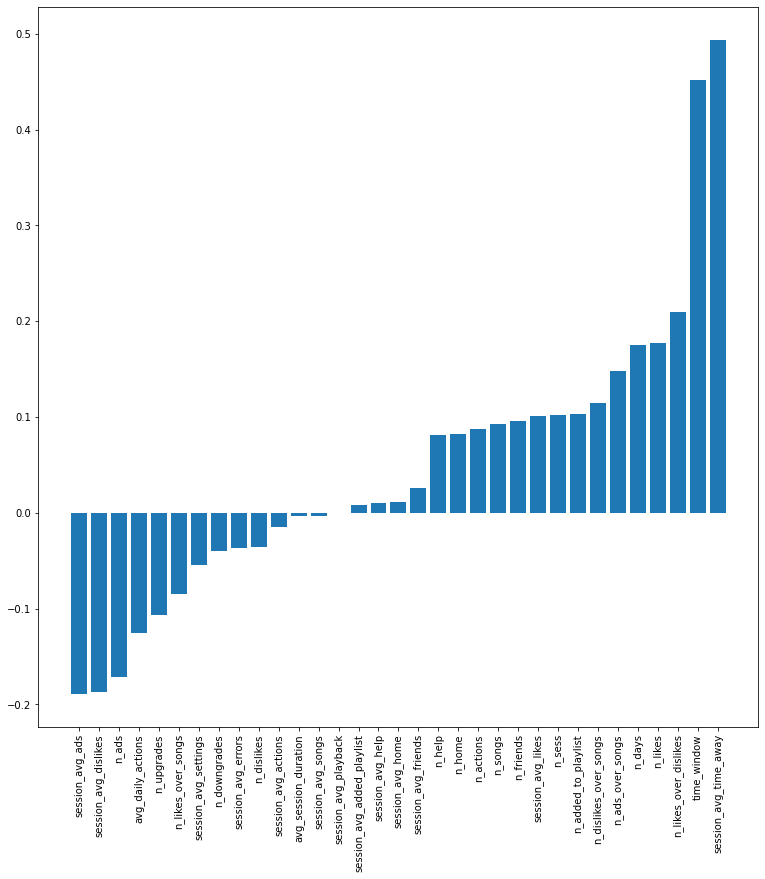

In [142]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 10))

ax = fig.add_axes([0, 0, 1, 1])
 
ax.bar(list(df_scores.feature), list(df_scores.score))

plt.xticks(rotation=90)

plt.show()

In [41]:
import pandas as pd 

def show_results_and_save(model_pipeline, predictions):
    
    df_results = predictions.select(['canceled', 'prediction']).toPandas()
    df_results['prediction'] = df_results.prediction.apply(int)

    # Display the results
    _metrics = plot_metrics(df_results['canceled'], df_results['prediction'])
    
    # Save the results
    _model = model_pipeline.bestModel.stages[-1]
    _model_name = _model.__class__.__name__

    _model_info = {
        'model_name' : _model_name,
        'hyperparameters' : list(zip(list(map(lambda _param: _param.name, list(_model.extractParamMap()))), list(_model.extractParamMap().values())))
    }

    _metrics.update(_model_info)

    _df_metrics = pd.DataFrame([_metrics])
    _df_metrics.to_csv(f'spark_{_model_name}.csv', index = False)

#### Logistic Regression

In [42]:
pipeline = create_logistic_regression_pipeline()
lr = logistic_regression_grid_search(pipeline)

# Train
model_pipeline = lr.fit(train_df)

# Test
predictions = model_pipeline.bestModel.transform(test_df)

# Show metrics
show_results_and_save(model_pipeline, predictions)

[[1032  264]
 [ 602 4069]]

accuracy................. 0.8549
precision................ 0.6316
recall................... 0.7963
auc...................... 0.8337
beta..................... 0.7568
F1 macro................. 0.8041
F1 micro................. 0.8549
F1 weighted.............. 0.8605
F1 binary................ 0.7044


#### Decision Tree Classifier

In [43]:
pipeline = create_decision_tree_pipeline()
dt = decision_tree_grid_search(pipeline)

# Train
model_pipeline = dt.fit(train_df)

# Test
predictions = model_pipeline.bestModel.transform(test_df)

# Show metrics
show_results_and_save(model_pipeline, predictions)

Number of models to train: 40
[[ 853  443]
 [ 238 4433]]

accuracy................. 0.8859
precision................ 0.7819
recall................... 0.6582
auc...................... 0.8036
beta..................... 0.6797
F1 macro................. 0.8217
F1 micro................. 0.8859
F1 weighted.............. 0.8822
F1 binary................ 0.7147


#### Random Forest

In [157]:
pipeline = create_random_forest_pipeline()
rf = random_forest_grid_search(pipeline)

# Train
model_pipeline = rf.fit(train_df)

# Test
predictions = model_pipeline.bestModel.transform(test_df)

# Show metrics
show_results_and_save(model_pipeline, predictions)

Number of models to train: 200
[[ 883  440]
 [ 140 4547]]

accuracy................. 0.9035
precision................ 0.8631
recall................... 0.6674
auc...................... 0.8188
beta..................... 0.6991
F1 macro................. 0.8464
F1 micro................. 0.9035
F1 weighted.............. 0.8988
F1 binary................ 0.7528


#### Gradient Boost

In [158]:
pipeline = create_gradient_boost_pipeline()
gb = gradient_boost_grid_search(pipeline)

# Train
model_pipeline = gb.fit(train_df)

# Test
predictions = model_pipeline.bestModel.transform(test_df)

# Show metrics
show_results_and_save(model_pipeline, predictions)

Number of models to train: 150
[[ 915  408]
 [ 181 4506]]

accuracy................. 0.9020
precision................ 0.8349
recall................... 0.6916
auc...................... 0.8265
beta..................... 0.7162
F1 macro................. 0.8476
F1 micro................. 0.9020
F1 weighted.............. 0.8986
F1 binary................ 0.7565


##### Estimator params and score

In [ ]:
import pandas as pd

scores = cv_gbt_results.avgMetrics
params = [{p.name: v for p, v in m.items()} for m in cv_gbt.getEstimatorParamMaps()]
params_pd = pd.DataFrame(params)
params_pd['score'] = scores
params_pd

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.